In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.5381MHz', 'g23': '121.9492MHz'}


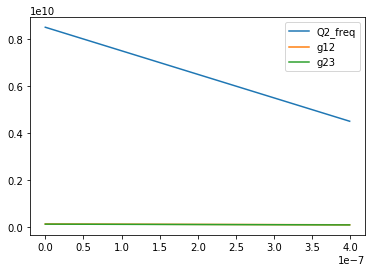

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

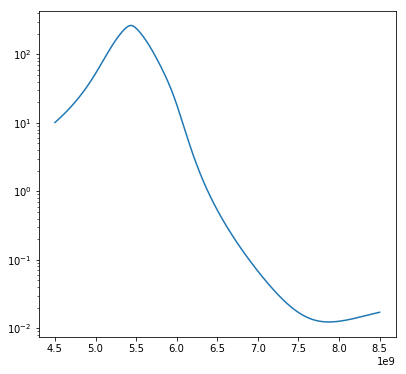

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib qt

In [5]:
def cost_func(pulse_params,*args):
    gate_time,SRATE,f_term=args

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=7.87e9,Q2_freq=5.4e9,constant_coupling=False,r1c=0.018,r2c=0.018,r12=0.0015,anhar_CPLR=-300e6,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=6.87e9,gap_threshold=6e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
        

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('lamb:',lamb1)
    print('error:',1-fidelity)
    return 1 - fidelity

def cost_func_inhomogeneity(pulse_params,*args):
    gate_time,SRATE,f_term,factor_idx,fac=args
    str_idx = bin(int(factor_idx))[2:6].zfill(4)
    factor1=1.0 + (int(str_idx[1])*2-1)*fac
    factorc=1.0 + (int(str_idx[2])*2-1)*fac
    factor2=1.0 + (int(str_idx[3])*2-1)*fac
    factor_r=1.0 
    
    lamb1 = pulse_params
    total_len = gate_time + 8e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
                 anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r-1,3e-9))
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    return 1 - fidelity

In [117]:
def cost_func_distor(pulse_params,*args):
    gate_time,SRATE,f_term,factor_r,T_reflex=args
#     str_idx = bin(int(factor_idx))[2:6].zfill(4)
    factor1=1.0 
    factorc=1.0 
    factor2=1.0 
    
    lamb1 = pulse_params
    total_len = gate_time + 12e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
                 anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r,T_reflex))
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    return 1 - fidelity

In [23]:
gate_time=60e-9
SRATE=10e9
f_term=1
factor_r=0.0
T_reflex=5e-9

factor1=1.0 
factorc=1.0 
factor2=1.0 

lamb1 = 1.2
total_len = gate_time + 30e-9

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
             CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
             anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
Seq.add_filter('Gauss Low Pass',300e6)
Seq.add_filter('Reflection',*(factor_r,T_reflex))
flux_pulse=Seq.get_sequence()



fig=plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)

ax.plot(flux_pulse)
ax.axis('off')

(-45.0, 945.0, -0.01794244634278362, 0.3767913731984528)

In [19]:
%matplotlib qt

In [21]:
gate_time=60e-9
SRATE=10e9
f_term=1
factor_r=0.0
T_reflex=5e-9

factor1=1.0 
factorc=1.0 
factor2=1.0 

lamb1 = 1.36
total_len = gate_time + 30e-9

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Slepian',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array([1.2,0.2]),
             Coupling=20e6,Offset=800e6,dfdV=500e6,negative_amplitude = True)
Seq.add_filter('Gauss Low Pass',300e6)
Seq.add_filter('Reflection',*(factor_r,T_reflex))
flux_pulse=Seq.get_sequence()


fig=plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)

ax.plot(flux_pulse)
ax.axis('off')

(-45.0, 945.0, -0.08168865261609544, 1.715461704937989)

In [90]:
SRATE=10e9
f_terms=1
gate_time_arr = np.arange(12e-9,60.1e-9,1e-9)

for fac_idx in np.arange(0,7.1,1):
    gate_fidelity_one = []
    gate_params_one = []
    raw_initial_seeds=np.array([3])
    for gate_time in gate_time_arr:
        time_start = time.time()
        DATA = sci_op.minimize(cost_func_inhomogeneity,raw_initial_seeds,args=(gate_time,SRATE,f_terms,fac_idx,0.05), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})
    #     DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,f_terms), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})

        gate_fidelity_one.append(DATA.fun)
        gate_params_one.append(DATA.x)
        raw_initial_seeds =DATA.x*0.92
        print('gate time',gate_time)
        print('fidelity',DATA.fun)
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\params_one_5_inhomo'+str(fac_idx)+'.txt',gate_params_one )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\error_one_5_inhomo'+str(fac_idx)+'.txt',gate_fidelity_one )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\gate_time_one_5_inhomo'+str(fac_idx)+'.txt',gate_time_arr )

In [57]:
param_one1 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\params_one1.txt' )
error_one1 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\error_one1.txt' )
gate_time_one1 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\gate_time_one1.txt' )

# param_one_imhomo_002 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\params_one_inhomo_002.txt' )
# error_one_imhomo_002 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_one_inhomo_002.txt' )
# gate_time_one_imhomo_002 =np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time_inhomo_002.txt' )

# param_one_imhomo_h004 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\params_one_inhomo_h004.txt' )
# error_one_imhomo_h004 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_one_inhomo_h004.txt' )
# gate_time_one_imhomo_h004 =np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time_inhomo_h004.txt' )

# param_one_imhomo_004 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\params_one_inhomo_004.txt' )
# error_one_imhomo_004 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_one_inhomo_004.txt' )
# gate_time_one_imhomo_004 =np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time_inhomo_004.txt' )

error_two_new6 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_two6.txt' )
param_two_new6 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\params_two6.txt' )
gate_time_new6 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time6.txt' )
error_two_new5 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_two5.txt' )
param_two_new5 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\params_two5.txt' )
gate_time_new5 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time5.txt' )
error_two_new4 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_two4.txt' )
param_two_new4 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\params_two4.txt' )
gate_time_new4 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time4.txt' )
error_two_new3 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_two3.txt' )
gate_time_new3 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time3.txt' )
error_two_new2 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_two2.txt' )
gate_time_new2 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time2.txt' )
error_two_new1 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\error_two.txt' )
gate_time_new1 = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\gate_time.txt' )

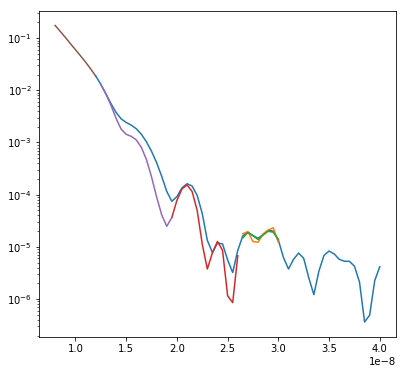

In [67]:
gate_time_arr = np.arange(12e-9,60.1e-9,2e-9)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)
ax.plot(gate_time_one1,error_one1)
# ax.plot(gate_time_one_imhomo_002,error_one_imhomo_002)
# ax.plot(gate_time_one_imhomo_004,error_one_imhomo_004,'r')
# ax.plot(gate_time_one_imhomo_h004,error_one_imhomo_h004,'--r')

ax.plot( gate_time_new6[0:len(error_two_new6)],error_two_new6)
ax.plot( gate_time_new5[0:len(error_two_new5)],error_two_new5)
ax.plot( gate_time_new4[0:len(error_two_new4)],error_two_new4)
ax.plot( gate_time_new3[0:len(error_two_new3)],error_two_new3)
ax.plot( gate_time_new2[0:len(error_two_new2)],error_two_new2)

ax.set_yscale('log')

## pulse func

In [9]:
def eigensolve_close(H):
    '''
    get eigensolution of hamiltonian 'H'.
    '''
    vals, vecs = eig(H)    
    for i in range(len(vecs[:,1])):
        idx=np.append(range(i),(-abs(vecs[i,i:])).argsort()+i) if i>0 else (-abs(vecs[i,i:])).argsort()   
        vecs=vecs[:,idx]
        vals=vals[idx]
    return np.real(vals), vecs

def eigensolve_sort(H,ascending = True):
    '''
      get eigensolution of hamiltonian 'H', default ascending order is True.
      The return eigenenergies are in ascending order is ascending is True, else they will be is descending order.
    '''
    vals, vecs = eig(H)    
    if ascending:
        idx = vals.argsort()
    else:
        idx = vals.argsort()[::-1] 
    vals = vals[idx]
    vecs = vecs[:,idx]
    return np.real(vals), vecs

def create(n):
    A = np.zeros([n,n])*1j
    for i in range(n-1):
        A[i+1,i] = np.sqrt(i+1)*(1+0j)
    return A

def destroy(n):
    return create(n).conj().transpose()

def mat_mul_all(*args):
    if len(args)<2:
        return args
    else:
        A = args[0]
        for i in range(1,len(args)):
            A = np.matmul(A,args[i])
    return A


In [10]:
import numpy as np
import scipy
import copy
from scipy import interpolate 
from scipy.linalg import eig
import numpy.linalg as LA
##########  copy from labber drivers ##############

class Pulse:
    """Represents physical pulses played by an AWG.

    Parameters
    ----------
    complex_value : bool
        If True, pulse has both I and Q, otherwise it's real valued.
        Phase, frequency and drag only applies for complex_value waveforms.

    Attributes
    ----------
    amplitude : float
        Pulse amplitude.
    width : float
        Pulse width.
    plateau : float
        Pulse plateau.
    frequency : float
        SSB frequency.
    phase : float
        Pulse phase.
    use_drag : bool
        If True, applies DRAG correction.
    drag_coefficient : float
        Drag coefficient.
    drag_detuning : float
        Applies a frequnecy detuning for DRAG pulses.
    start_at_zero : bool
        If True, forces the pulse to start in 0.

    """

    def __init__(self,complex_value = False):

        # set variables
        self.amplitude = 0.5
        self.width = 10E-9
        self.plateau = 0.0
        self.frequency = 0.0
        self.phase = 0.0
        self.use_drag = False
        self.drag_coefficient = 0.0
        self.drag_detuning = 0.0
        self.start_at_zero = False
        self.complex_value = complex_value
        self.pulse_trunc = False
        self.trunc_start = 0
        self.trunc_end = 0

        # For IQ mixer corrections
        self.iq_ratio = 1.0
        self.iq_skew = 0.0

    def show_params(self):
        print(self.__dict__)

    def total_duration(self):
        """Get the total duration for the pulse.

        Returns
        -------
        float
            Total duration in seconds.

        """
        raise NotImplementedError()

    def calculate_envelope(self, t0, t):
        """Calculate pulse envelope.

        Parameters
        ----------
        t0 : float
            Pulse position, referenced to center of pulse.

        t : numpy array
            Array with time values for which to calculate the pulse envelope.

        Returns
        -------
        waveform : numpy array
            Array containing pulse envelope.

        """
        raise NotImplementedError()

    def calculate_waveform(self, t0, t):
        """Calculate pulse waveform including phase shifts and SSB-mixing.

        Parameters
        ----------
        t0 : float
            Pulse position, referenced to center of pulse.

        t : numpy array
            Array with time values for which to calculate the pulse waveform.

        Returns
        -------
        waveform : numpy array
            Array containing pulse waveform.

        """
        y = self.calculate_envelope(t0, t)
        # Make sure the waveform is zero outside the pulse
        y[t < (t0 - self.total_duration() / 2)] = 0
        y[t > (t0 + self.total_duration() / 2)] = 0

        if self.pulse_trunc == True:
            y[t < self.trunc_start] = 0
            y[t >= self.trunc_end] = 0

        if self.use_drag:
            beta = self.drag_coefficient / (t[1] - t[0])
            y = y + 1j * beta * np.gradient(y)
            y = y * np.exp(1j * 2 * np.pi * self.drag_detuning *
                           (t - t0 + 0*self.total_duration() / 2))

        # Apply phase and SSB
        phase = self.phase
        # single-sideband mixing, get frequency
        omega = 2 * np.pi * self.frequency
        # apply SSBM transform
        data_i = self.iq_ratio * (y.real * np.cos(omega * t - phase) +
                                    - y.imag * np.cos(omega * t - phase +
                                                    np.pi / 2))
        data_q = (y.real * np.sin(omega * t - phase + self.iq_skew) +
                    -y.imag * np.sin(omega * t - phase + self.iq_skew +
                                    np.pi / 2))
        


        if self.complex_value:
            return data_i + 1j * data_q
        else:
            return data_i

In [11]:
class Adiabatic(Pulse):
    
    def __init__(self, complex_value=False ,*args, **kwargs):
        super().__init__(complex_value)

        self.Q1_freq = 6.0e9
        self.CPLR_idle_freq = 8e9
        self.Q2_freq = 5.4e9
        self.constant_coupling = False 
        ## if not constant_coupling, use r1c r2c
        self.g1c = 100e6 ## coupling strength
        self.g2c = 100e6
        self.g12 = 12e6
        self.r1c = 0.016
        self.r2c = 0.016
        self.r12 = 0.001
        self.anhar_Q1 = -250e6
        self.anhar_Q2 = -250e6
        self.anhar_CPLR = -400e6
        
        self.F_Terms = 2
        self.Lcoeff = np.array([1,0.1])
        self.dfdV = 500e6
        self.negative_amplitude = False
        self.gap_threshold = 10e6
        self.pulsepoints = 801
        self.freqpoints = 401
        
    def total_duration(self):
        return self.width+self.plateau
    
    def calculate_envelope(self,t0,t):
        self.get_adia_factor_spline()
        self.calculate_f_t_sinosoidal()
        ft_spline = interpolate.splrep(self.t_arr,self.f_t_arr,k=3)
        
        values = np.zeros_like(t) 
        x1 = ( abs(t - t0) <=  self.plateau/2 + self.width/2)   
        x2 = ( abs(t - t0) < self.plateau/2 )
        values[x1] = self.CPLR_idle_freq -interpolate.splev( (self.width/2+abs(t[x1]-t0)-self.plateau/2)/self.width,ft_spline )
        values[x2] =self.CPLR_idle_freq-interpolate.splev( 0.5 ,ft_spline )
        
        if self.negative_amplitude:
            values = values*-1
        return values/self.dfdV

    def get_Hamiltonian(self,fc):
        if not self.constant_coupling:
            g1c = self.r1c*np.sqrt(self.Q1_freq*fc)
            g2c = self.r2c*np.sqrt(self.Q2_freq*fc)
            g12 = self.r12*np.sqrt(self.Q2_freq*self.Q1_freq)
        else:
            g1c = self.g1c
            g2c = self.g2c
            g12 = self.g12
        fq1 = self.Q1_freq
        fq2 = self.Q2_freq
        anhar1 = self.anhar_Q1
        anharc = self.anhar_CPLR
        anhar2 = self.anhar_Q2
            
        Hq1 = fq1*mat_mul_all(create(3),destroy(3))+anhar1/2*mat_mul_all(create(3),create(3),destroy(3),destroy(3))
        Hq1_full = np.kron(np.kron(Hq1,np.eye(3)),np.eye(3))
        Hc = fc*mat_mul_all(create(3),destroy(3))+anharc/2*mat_mul_all(create(3),create(3),destroy(3),destroy(3))
        Hc_full = np.kron(np.kron(np.eye(3),Hc),np.eye(3))
        Hq2 = fq2*mat_mul_all(create(3),destroy(3))+anhar2/2*mat_mul_all(create(3),create(3),destroy(3),destroy(3))
        Hq2_full = np.kron(np.kron(np.eye(3),np.eye(3)),Hq2)
        H_g1c = g1c*np.kron(np.kron(create(3)+destroy(3),create(3)+destroy(3) ),np.eye(3))
        H_g2c = g2c*np.kron(np.kron(np.eye(3),create(3)+destroy(3) ),create(3)+destroy(3))
        H_g12 = g12*np.kron(np.kron(create(3)+destroy(3),np.eye(3)),create(3)+destroy(3) )
        return Hq1_full+Hc_full+Hq2_full+H_g1c+H_g2c+H_g12
    
    def get_eigen(self,fc,position_index=False):  
        self.H = self.get_Hamiltonian(fc)
        eigen_eners,eigen_states = eigensolve_sort(self.H)
        if position_index:
            return eigen_eners[position_index],eigen_states.T[position_index]
        else:
            return eigen_eners,eigen_states.T

    def get_maximum_overlap_index(self,H):
        ## be careful using this function, it may fail in degenerate case !!!!
        eigenvalues = eigensolve_close(H)[0]
        position_index = np.argsort(eigenvalues)
        return np.argsort(position_index)
    
    def get_derivative_state(self,state_trace,df):
        deriv_list = [ (state_trace[i+1]-state_trace[i-1])/2/df for i in range(1,len(state_trace)-1)] 
        deriv_list.insert(0, (state_trace[1]-state_trace[0])/df )
        deriv_list.append( (state_trace[-1]-state_trace[-2])/df )
        return deriv_list

    def smooth_state_trace(self,state_list,inver_direc = False):
        last_state = state_list[0] 
        new_state_list = [last_state]
        for i in range(1,len(state_list)):
            if LA.norm(state_list[i] - last_state) >= LA.norm(state_list[i] + last_state):
                last_state = -1* state_list[i]
            else:
                last_state = state_list[i]
            new_state_list.append(last_state)
        return np.array(new_state_list)

    def get_adia_factor(self,alpha,beta,E_alpha,E_beta,df):
        alpha_deriv = self.get_derivative_state( self.smooth_state_trace(alpha),df )
        beta_smooth = self.smooth_state_trace(beta)
        return np.array([ np.dot(beta_smooth[i].T.conj(),alpha_deriv[i])/(E_alpha[i]-E_beta[i]) for i in range(len(alpha_deriv))])
    
    
    def get_adia_factor_spline(self):
        self.fc_arr = np.linspace(self.Q2_freq-600e6,self.CPLR_idle_freq+100e6,self.freqpoints)[::-1]
        df = self.fc_arr[1]-self.fc_arr[0]
        
        position_idx = self.get_maximum_overlap_index(self.get_Hamiltonian(self.fc_arr[0]))
        self.Ener_All=[]
        self.Estate_All=[]
        for fc in self.fc_arr:
            eigen_eners,eigen_states = self.get_eigen(fc)
            self.Ener_All.append(eigen_eners)
            self.Estate_All.append(eigen_states)
        self.Ener_All = np.asarray(self.Ener_All)
        self.Estate_All = np.asarray(self.Estate_All)
        if self.gap_threshold:
            self.rearrangement_eigen_traces_by_ignore_small_gap()

        # 001,010,100,011,101,110,002,020,200
        Ener9trace = [[],[],[],[],[],[],[],[],[]]
        Estate9trace = [[],[],[],[],[],[],[],[],[]]
        for trace_idx in range(len(self.Ener_All)):
            for ii,idx in enumerate([1,3,9,4,10,12,2,6,18]):
                Ener9trace[ii].append( self.Ener_All[trace_idx][position_idx][idx]  ) 
                Estate9trace[ii].append( self.Estate_All[trace_idx][position_idx][idx]  )                
                
        self.Adia_Factor_Total = 0
        self.Adia_Factor_Total += np.abs( self.get_adia_factor( Estate9trace[0],Estate9trace[1],Ener9trace[0],Ener9trace[1],df) )
        self.Adia_Factor_Total += np.abs( self.get_adia_factor( Estate9trace[0],Estate9trace[2],Ener9trace[0],Ener9trace[2],df) )
        self.Adia_Factor_Total += np.abs( self.get_adia_factor( Estate9trace[1],Estate9trace[2],Ener9trace[1],Ener9trace[2],df) )
        for jj in [4]:
            for kk in range(3,9):
                if kk !=jj:
                    self.Adia_Factor_Total += np.abs(self.get_adia_factor( Estate9trace[jj],Estate9trace[kk],Ener9trace[jj],Ener9trace[kk],df))
        self.adia_spline = interpolate.splrep(self.fc_arr[::-1],self.Adia_Factor_Total[::-1],k=3)

    def calculate_f_t_sinosoidal(self):
        n = np.arange(1, self.F_Terms + 1, 1)
        n_points = self.pulsepoints  # Number of points in the numerical integration
        self.t_arr = np.linspace(0, 1, n_points)
        self.dt = (self.t_arr[1]-self.t_arr[0])*self.width
        
        f_t0=self.CPLR_idle_freq
        f_t_arr = np.array([f_t0])
        for i in range( int((n_points-1)/2) ):
            df_dt = -1*np.sum(self.Lcoeff*( np.sin(2*np.pi*n*self.t_arr[i])))/interpolate.splev(f_t0,self.adia_spline)  
            f_t0 += df_dt * self.dt
            f_t_arr =np.append( f_t_arr, f_t0 )
        self.f_t_arr = np.append(f_t_arr,f_t_arr[-2::-1])

    def rearrangement_eigen_traces_by_ignore_small_gap(self):
        for i in range(len(self.Ener_All[0])-1):
            self.swap_two_eigen_trace(self.Ener_All[:,i],self.Ener_All[:,i+1],self.Estate_All[:,i],self.Estate_All[:,i+1],self.gap_threshold )

    def swap_two_eigen_trace(self,eigen_ener1,eigen_ener2,eigen_state1,eigen_state2,gap):
        ener_diff = eigen_ener2 - eigen_ener1
        anticross_idx = np.where( ener_diff < gap )[0]
        if len(anticross_idx) == 0 or isinstance(ener_diff,float):
            pass
        else:
            extreme_points  = self.get_extreme_points(ener_diff,anticross_idx)
            for point in extreme_points:
                eigen_ener1_temp = copy.deepcopy(eigen_ener1)
                eigen_state1_temp = copy.deepcopy(eigen_state1)
                eigen_ener1[point:] = eigen_ener2[point:]
                eigen_ener2[point:] = eigen_ener1_temp[point:]
                eigen_state1[point:] = eigen_state2[point:]
                eigen_state2[point:] = eigen_state1_temp[point:]

    def get_extreme_points(self,ener_diff,anticross_idx):
        start_idxs = [anticross_idx[0]]
        end_idxs = []
        for idx_count,idx in enumerate(anticross_idx):
            if idx+1 in anticross_idx:
                continue
            else:
                end_idxs.append(idx)
                if idx_count != len(anticross_idx)-1:
                    start_idxs.append(anticross_idx[idx_count+1])
        extreme_points = []
        for i in range(len(start_idxs)):
            if start_idxs[i] == end_idxs[i]:
                extreme_points.append(start_idxs[i])
            else:
                extreme_points.append( np.argmin(ener_diff[start_idxs[i]:end_idxs[i]])+start_idxs[i] )    
        return extreme_points




In [12]:
pulse = Adiabatic()
pulse.width=30e-9
pulse.pleatau=0e-9
pulse.gap_threshold=10e6
# pulse.dfdV = 7.500e9

# pulse.Q1_freq = 6.0e9
# pulse.Q2_freq = 5.4e9

pulse.Q1_freq = 6.0e9
pulse.CPLR_idle_freq = 7.8e9
pulse.Q2_freq = 5.4e9
pulse.constant_coupling = False 
## if not constant_coupling, use r1c r2c
pulse.g1c = 100e6 ## coupling strength
pulse.g2c = 100e6
pulse.g12 = 12e6
pulse.r1c = 0.016
pulse.r2c = 0.016
pulse.r12 = 0.001
pulse.anhar_Q1 = -250e6
pulse.anhar_Q2 = -250e6
pulse.anhar_CPLR = -400e6

In [13]:
t_arr= np.linspace(-60e-9,60e-9,241)
# time_start = time.time()
A4 = pulse.calculate_envelope(0e-9,t_arr)

In [ ]:
A4.ad

0.38497018814086914


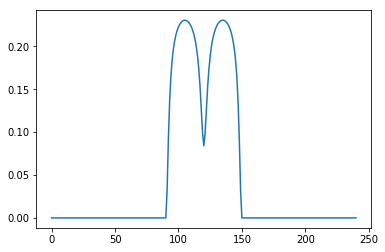

In [82]:
fig=plt.figure()
ax=fig.add_subplot(111)
    
factors=np.linspace(-0.4,0.4,1)
for fac in factors:
    pulse = Adiabatic()
    pulse.width=30e-9
    pulse.pleatau=0e-9
    pulse.gap_threshold=10e6
    pulse.dfdV = 7.500e9
    pulse.Q2_freq = 5.0e9
    pulse.F_Terms = 2
    pulse.Lcoeff = np.array([0,0.2])
    pulse.pulsepoints=501
    pulse.freqpoints = 201

    t_arr= np.linspace(-60e-9,60e-9,241)
    time_start = time.time()
    A4 = pulse.calculate_envelope(0e-9,t_arr)
    print(time.time()-time_start)


    ax.plot(A4)